We are going to work in the competition: House Prices - Advanced Regression Techniques ( https://www.kaggle.com/c/house-prices-advanced-regression-techniques )


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pip install optuna


     |████████████████████████████████| 296kB 7.7MB/s 
     |████████████████████████████████| 81kB 10.8MB/s 
     |████████████████████████████████| 163kB 26.2MB/s 
     |████████████████████████████████| 112kB 27.4MB/s 
     |████████████████████████████████| 51kB 8.3MB/s 
     |████████████████████████████████| 143kB 25.0MB/s 
     |████████████████████████████████| 81kB 10.7MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-cp37-none-any.whl size=11107 sha256=fed553448916e02f45db22ddb6d284b2e1e973237df64af68b5868fb9e8325a7
  Stored in directory: /root/.cache/pip/wheels/25/af/b8/3407109267803f4015e1ee2ff23be0c8c19ce4008665931ee1
Successfully built pyperclip


In [3]:
pip install catboost --no-cache-dir

     |████████████████████████████████| 67.3MB 1.3MB/s 


In [4]:
pip install shap


     |████████████████████████████████| 358kB 9.9MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491621 sha256=abf535984f22ac69c683bf855fd1ac1198e5bae9237e9cc06ac742961f569ded
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [5]:
pip install -I shap


Processing /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283/shap-0.39.0-cp37-cp37m-linux_x86_64.whl
     |████████████████████████████████| 27.4MB 113kB/s 
     |████████████████████████████████| 22.3MB 89kB/s 
     |████████████████████████████████| 15.3MB 217kB/s 
     |████████████████████████████████| 9.9MB 53.7MB/s 
     |████████████████████████████████| 81kB 11.7MB/s 
     |████████████████████████████████| 3.4MB 46.6MB/s 
  Using cached https://files.pythonhosted.org/packages/78/c2/b3f55dfdb8af9812fdb9baf70cacf3b9e82e505b2bd4324d588888b81202/slicer-0.0.7-py3-none-any.whl
     |████████████████████████████████| 307kB 58.8MB/s 
     |████████████████████████████████| 235kB 61.3MB/s 
     |████████████████████████████████| 512kB 53.9MB/s 
     |████████████████████████████████| 788kB 48.2MB/s 
     |████████████████████████████████| 25.3MB 88kB/s 
ERROR: tensorflow 2.4.1 has requirement numpy~=1.19.2, but you'll have numpy 1.20.2 which is incompa

In [2]:
import pandas as pd
import numpy as np
import optuna
import xgboost
import catboost
import lightgbm as lgb
from lightgbm import LGBMRegressor 
import shap
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from math import sqrt
import seaborn as sns
from scipy.stats import skew
from numpy import mean, std
from sklearn.model_selection import RandomizedSearchCV, train_test_split, KFold, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor


In [3]:
# Import dataset
train = pd.read_csv("/content/drive/MyDrive/Ignacio Fiori Training/Machine Learning/HousePrices/train.csv")

**Exploration and Preprocessing of Data**

The first thing to do is to split our dataset.

In [4]:
train.shape

(1460, 81)

As we can see, we have 1460 rows with 81 features. Our goal is to predict the column name SalePrice. Besides, as we don't have so many rows, we'll split the dataset only in train and test datasets.

In [5]:
train, test=train_test_split(train, test_size=.2)

In [6]:
print(train.shape)
print(test.shape)

(1168, 81)
(292, 81)


In [7]:
# Visualize some elements of the dataset to see how it looks
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1208,1209,20,RL,70.0,7763,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1962,1980,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,Gd,CBlock,TA,TA,No,Rec,504,BLQ,108,319,931,GasA,...,Y,SBrkr,1283,0,0,1283,1,0,1,0,3,1,TA,6,Typ,0,NaN,Detchd,1980.0,Unf,2,506,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,10,2008,WD,Normal,140000
1133,1134,60,RL,80.0,9828,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,2Story,8,5,1995,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,No,GLQ,584,Unf,0,544,1128,GasA,...,Y,SBrkr,1142,878,0,2020,0,0,2,1,3,1,Gd,8,Typ,1,TA,Attchd,1995.0,RFn,2,466,TA,TA,Y,0,155,0,0,0,0,NaN,NaN,NaN,0,6,2009,WD,Normal,239500
309,310,20,RL,90.0,12378,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,9,5,2003,2004,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Ex,TA,Gd,GLQ,1274,Unf,0,622,1896,GasA,...,Y,SBrkr,1944,0,0,1944,1,0,2,0,3,1,Ex,8,Typ,3,Ex,Attchd,2003.0,Fin,3,708,TA,TA,Y,208,175,0,0,0,0,NaN,NaN,NaN,0,11,2006,WD,Normal,360000
257,258,20,RL,68.0,8814,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,1Story,7,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,Stone,180.0,Gd,TA,PConc,Gd,TA,No,GLQ,1334,Unf,0,270,1604,GasA,...,Y,SBrkr,1604,0,0,1604,1,0,2,1,3,1,Gd,8,Typ,1,Gd,Attchd,2006.0,RFn,2,660,TA,TA,Y,123,110,0,0,0,0,NaN,NaN,NaN,0,3,2009,WD,Abnorml,220000
1318,1319,20,RL,NaN,14781,Pave,NaN,IR2,Lvl,AllPub,CulDSac,Gtl,CollgCr,Norm,Norm,1Fam,1Story,8,5,2001,2002,Hip,CompShg,VinylSd,VinylSd,BrkFace,178.0,Gd,TA,PConc,Gd,TA,Gd,Unf,0,Unf,0,1753,1753,GasA,...,Y,SBrkr,1787,0,0,1787,0,0,2,0,3,1,Gd,7,Typ,1,TA,Attchd,2001.0,RFn,3,748,TA,TA,Y,198,150,0,0,0,0,NaN,NaN,NaN,0,8,2006,WD,Normal,275000


In just a few rows we can see that we have NaN values, later we'll have to deal with them

In [8]:
train.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

In [9]:
quantitative = [feature for feature in train.columns if train.dtypes[feature] != 'object']
qualitative = [feature for feature in train.columns if train.dtypes[feature] == 'object']

We have a lot of categorial variables. We have to see how to deal with them


**Correlation Analysis**

Let see the most correlated features.



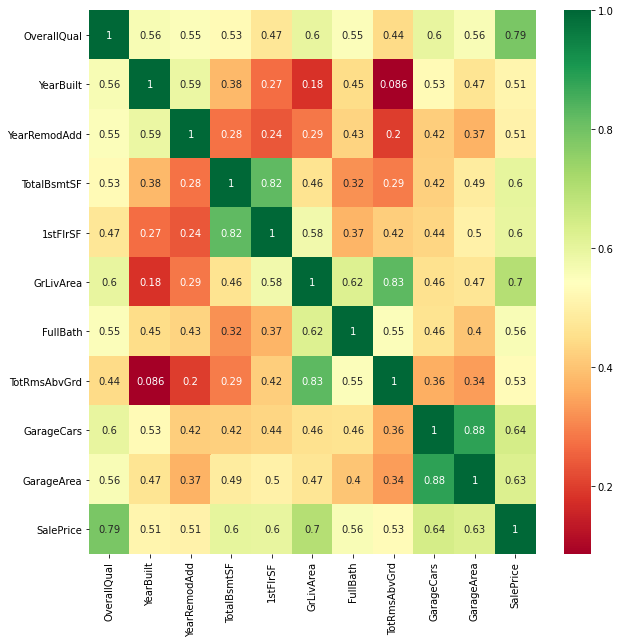

In [10]:
# most correlated features
corrmat = train.corr()
top_corr_features = corrmat.index[abs(corrmat["SalePrice"])>0.5]
plt.figure(figsize=(10,10))
g = sns.heatmap(train[top_corr_features].corr(),annot=True,cmap="RdYlGn")




*   From this we can tell which features (OverallQual, GrLivArea and TotalBsmtSF ) are highly positively correlated with the SalePrice.
*   Garage Cars and Garage Are also seems correlated between them since the numbers of car that will fit into the garage will depend on Garage Area.



Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


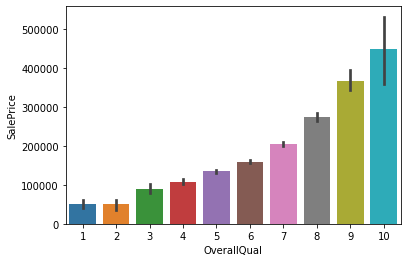

In [11]:
sns.barplot(train.OverallQual,train.SalePrice)

We can see in this graph how when the rate of the OverallQual increases, the price also increases

Scatter plots between 'SalePrice' and correlated variables



The `size` parameter has been renamed to `height`; please update your code.


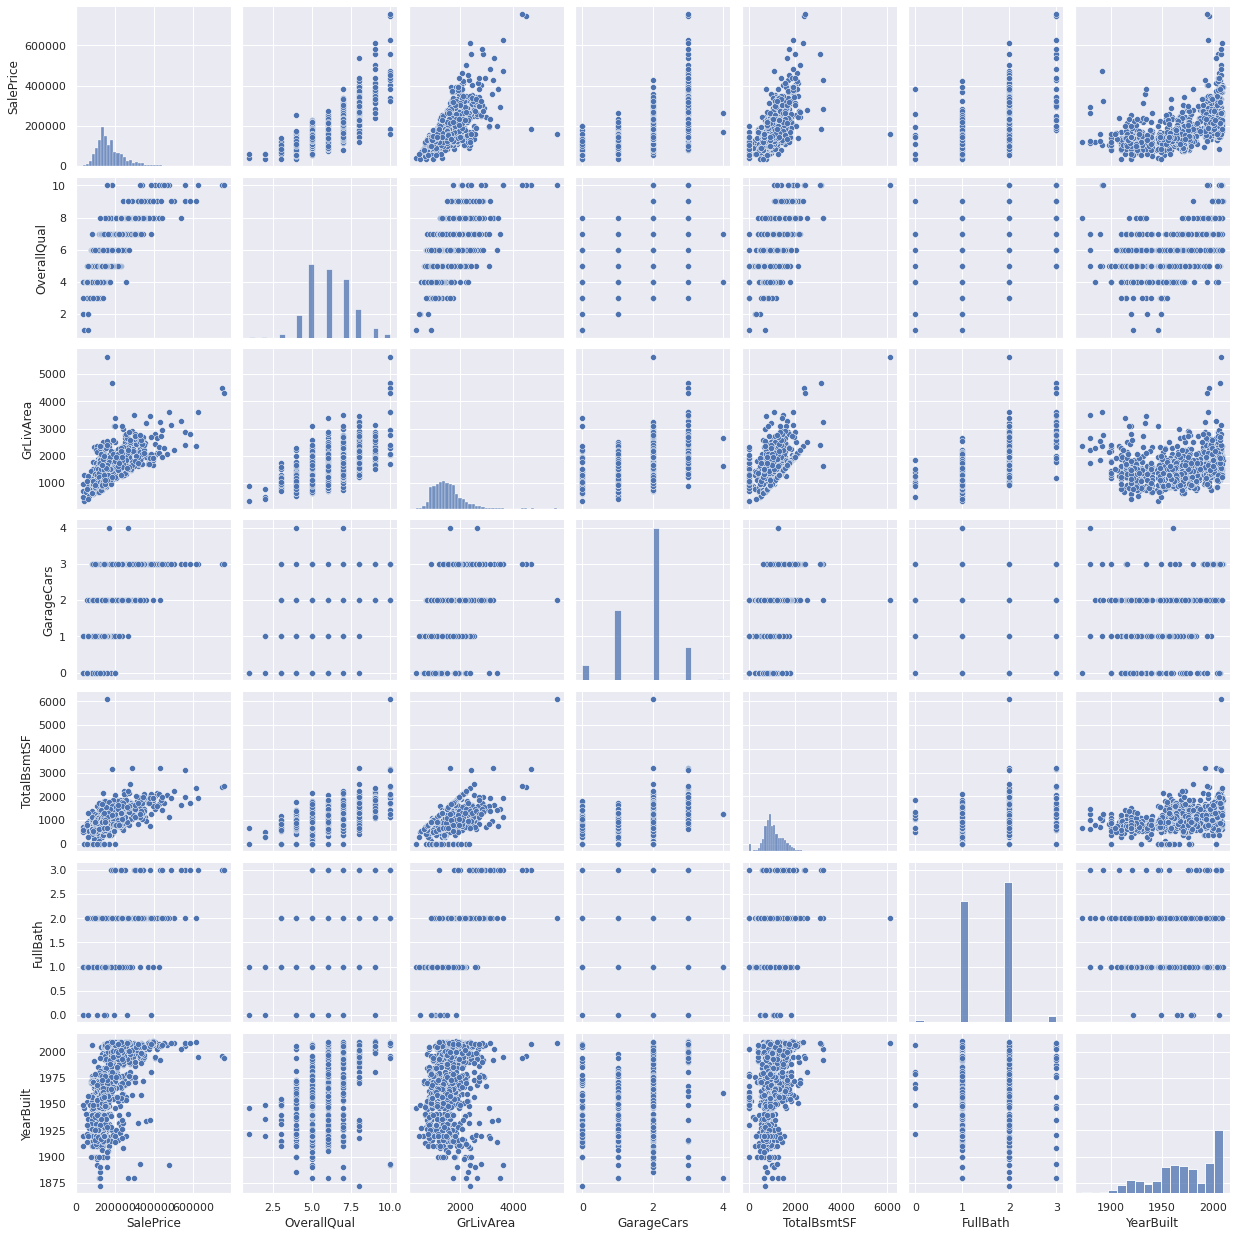

In [12]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train[cols], size = 2.5)
plt.show();

GrLiv Area and TotalBsmtSF seem to have linear relationship with SalePrice

**Feature Engineering**

In [13]:
#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

In [14]:
#Look at the variable to predict
train.SalePrice.describe()

count      1168.000000
mean     179868.146404
std       81120.823673
min       34900.000000
25%      129000.000000
50%      160000.000000
75%      212225.000000
max      755000.000000
Name: SalePrice, dtype: float64

**Skewness of target feature**

Skew is:  2.026440093822651


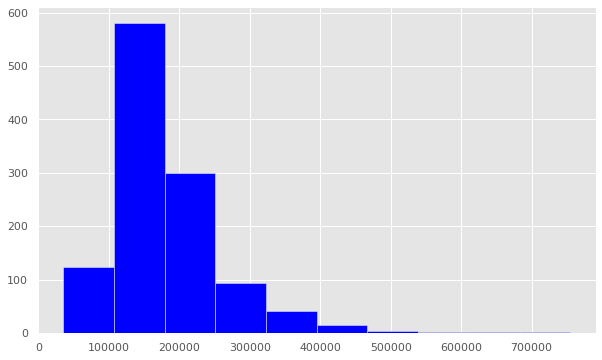

In [15]:
print("Skew is: ", train.SalePrice.skew())
plt.style.use(style="ggplot")
plt.rcParams["figure.figsize"]=(10,6)
plt.hist(train.SalePrice,color="blue")
plt.show()

Our variable to predict is skewed so we apply the logarithm. The logarithm reduces the dynamic range of a variable so the differences are preserved while the scale is not that dramatically skewed.

In [16]:
train["SalePrice"] = np.log1p(train["SalePrice"])
test["SalePrice"] = np.log1p(test["SalePrice"])

In [17]:
# Visualize all the features that have missing values
test_missing = test.isna().sum() / test.shape[0]
test_missing[test_missing > 0.0].sort_values(ascending=False)

PoolQC          0.996575
Alley           0.945205
MiscFeature     0.945205
Fence           0.821918
FireplaceQu     0.455479
LotFrontage     0.202055
GarageType      0.051370
GarageYrBlt     0.051370
GarageFinish    0.051370
GarageQual      0.051370
GarageCond      0.051370
BsmtExposure    0.027397
BsmtQual        0.023973
BsmtCond        0.023973
BsmtFinType1    0.023973
BsmtFinType2    0.023973
dtype: float64

In [18]:
# Visualize all the features that have missing values
train_missing = train.isna().sum() / train.shape[0]
train_missing[train_missing > 0.0].sort_values(ascending=False)

PoolQC          0.994863
MiscFeature     0.967466
Alley           0.935788
Fence           0.803938
FireplaceQu     0.476884
LotFrontage     0.171233
GarageType      0.056507
GarageYrBlt     0.056507
GarageFinish    0.056507
GarageQual      0.056507
GarageCond      0.056507
BsmtFinType2    0.026541
BsmtExposure    0.025685
BsmtFinType1    0.025685
BsmtCond        0.025685
BsmtQual        0.025685
MasVnrArea      0.006849
MasVnrType      0.006849
Electrical      0.000856
dtype: float64

We have four features wih more than 0.8 percent of NaN. GarageType, GarageFinish, GarageQual, GarageCond and GarageYrBlt have the same percentage of null values.

Let's start to deal with these NaN values

In [19]:
#NaN in Pool Quality means No Pool so replace these values by 'None'
train["PoolQC"] = train["PoolQC"].fillna("None")
test["PoolQC"] = test["PoolQC"].fillna("None")

In [20]:
# MiscFeature : Data documentation says NA means "no misc feature"
train["MiscFeature"] = train["MiscFeature"].fillna("None")
test["MiscFeature"] = test["MiscFeature"].fillna("None")

In [21]:
#Alley : data description says NA means "no alley access"
train["Alley"] = train["Alley"].fillna("None")
test["Alley"] = test["Alley"].fillna("None")

In [22]:
#Fence : data description says NA means "no fence"
train["Fence"] = train["Fence"].fillna("None")
test["Fence"] = test["Fence"].fillna("None")

In [23]:
#FireplaceQu : data description says NA means "no fireplace"
train["FireplaceQu"] = train["FireplaceQu"].fillna("None")
test["FireplaceQu"] = test["FireplaceQu"].fillna("None")

For LotFrontage we will fill the NA with the mean value of the feature

In [24]:
train_median = train["LotFrontage"].median()
train["LotFrontage"] = train["LotFrontage"].fillna(train_median)
test["LotFrontage"] = test["LotFrontage"].fillna(train_median)

For all the features related to Garage the NA means No Garage so we will put None

In [25]:
train["GarageType"] = train["GarageType"].fillna("None")
train["GarageFinish"] = train["GarageFinish"].fillna("None")
train["GarageQual"] = train["GarageQual"].fillna("None")
train["GarageCond"] = train["GarageCond"].fillna("None")
test["GarageType"] = test["GarageType"].fillna("None")
test["GarageFinish"] = test["GarageFinish"].fillna("None")
test["GarageQual"] = test["GarageQual"].fillna("None")
test["GarageCond"] = test["GarageCond"].fillna("None")

As NA means No Garage we will put 0 in GarageYrBlt as there isn't any garage built and the NA for the features related to Garage are in the same rows.

In [26]:
train["GarageYrBlt"] = train["GarageYrBlt"].fillna("0")
test["GarageYrBlt"] = test["GarageYrBlt"].fillna("0")

For all the features related to Bsmt NA means No Basement so we will put None in these values

In [27]:
train["BsmtFinType2"] = train["BsmtFinType2"].fillna("None")
train["BsmtExposure"] = train["BsmtExposure"].fillna("None")
train["BsmtQual"] = train["BsmtQual"].fillna("None")
train["BsmtFinType1"] = train["BsmtFinType1"].fillna("None")
train["BsmtCond"] = train["BsmtCond"].fillna("None")

test["BsmtFinType2"] = test["BsmtFinType2"].fillna("None")
test["BsmtExposure"] = test["BsmtExposure"].fillna("None")
test["BsmtQual"] = test["BsmtQual"].fillna("None")
test["BsmtFinType1"] = test["BsmtFinType1"].fillna("None")
test["BsmtCond"] = test["BsmtCond"].fillna("None")

For these two features as it's not clear that NA means no masonry veener we will replace the NA values by the values that appear most for the categorical feature MasVnrType and by the mean for MasVnrArea.

In [28]:
train_MVT_mode = train["MasVnrType"].mode()[0]
train_MVA_median = train["MasVnrArea"].median()

train["MasVnrType"] = train["MasVnrType"].fillna(train_MVT_mode)
train["MasVnrArea"] = train["MasVnrArea"].fillna(train_MVA_median)

test["MasVnrType"] = test["MasVnrType"].fillna(train_MVT_mode)
test["MasVnrArea"] = test["MasVnrArea"].fillna(train_MVA_median)


For Electrical we will replace the NA with the most frequent value also


In [29]:
train_electrical_mode = train["Electrical"].mode()[0]
train["Electrical"] = train["Electrical"].fillna(train_electrical_mode)
test["Electrical"] = test["Electrical"].fillna(train_electrical_mode)


In [30]:
# Visualize all the features that have missing values
train_missing = train.isna().sum() / train.shape[0]
train_missing[train_missing > 0.0].sort_values(ascending=False)

Series([], dtype: float64)

In [31]:
# Visualize all the features that have missing values
test_missing = test.isna().sum() / test.shape[0]
test_missing[test_missing > 0.0].sort_values(ascending=False)

Series([], dtype: float64)

In [32]:
train.shape

(1168, 80)

In [33]:
test.shape

(292, 80)

In [34]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1208,20,RL,70.0,7763,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1962,1980,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,Gd,CBlock,TA,TA,No,Rec,504,BLQ,108,319,931,GasA,TA,Y,SBrkr,1283,0,0,1283,1,0,1,0,3,1,TA,6,Typ,0,None,Detchd,1980.0,Unf,2,506,TA,TA,Y,0,0,0,0,0,0,None,None,None,0,10,2008,WD,Normal,11.849405
1133,60,RL,80.0,9828,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,2Story,8,5,1995,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,No,GLQ,584,Unf,0,544,1128,GasA,Ex,Y,SBrkr,1142,878,0,2020,0,0,2,1,3,1,Gd,8,Typ,1,TA,Attchd,1995.0,RFn,2,466,TA,TA,Y,0,155,0,0,0,0,None,None,None,0,6,2009,WD,Normal,12.386313
309,20,RL,90.0,12378,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,9,5,2003,2004,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Ex,TA,Gd,GLQ,1274,Unf,0,622,1896,GasA,Ex,Y,SBrkr,1944,0,0,1944,1,0,2,0,3,1,Ex,8,Typ,3,Ex,Attchd,2003.0,Fin,3,708,TA,TA,Y,208,175,0,0,0,0,None,None,None,0,11,2006,WD,Normal,12.793862
257,20,RL,68.0,8814,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,1Story,7,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,Stone,180.0,Gd,TA,PConc,Gd,TA,No,GLQ,1334,Unf,0,270,1604,GasA,Ex,Y,SBrkr,1604,0,0,1604,1,0,2,1,3,1,Gd,8,Typ,1,Gd,Attchd,2006.0,RFn,2,660,TA,TA,Y,123,110,0,0,0,0,None,None,None,0,3,2009,WD,Abnorml,12.301387
1318,20,RL,70.0,14781,Pave,None,IR2,Lvl,AllPub,CulDSac,Gtl,CollgCr,Norm,Norm,1Fam,1Story,8,5,2001,2002,Hip,CompShg,VinylSd,VinylSd,BrkFace,178.0,Gd,TA,PConc,Gd,TA,Gd,Unf,0,Unf,0,1753,1753,GasA,Ex,Y,SBrkr,1787,0,0,1787,0,0,2,0,3,1,Gd,7,Typ,1,TA,Attchd,2001.0,RFn,3,748,TA,TA,Y,198,150,0,0,0,0,None,None,None,0,8,2006,WD,Normal,12.524530


**Outliers**

An outlier is a data point that differs significantly from other observations

In [35]:
# Select numeric features to visualize outliers
numeric_features=train.select_dtypes(include=[np.number])
for (columnName, _) in numeric_features.iteritems(): 
    print('Column Name: ' + columnName) 

Column Name: MSSubClass
Column Name: LotFrontage
Column Name: LotArea
Column Name: OverallQual
Column Name: OverallCond
Column Name: YearBuilt
Column Name: YearRemodAdd
Column Name: MasVnrArea
Column Name: BsmtFinSF1
Column Name: BsmtFinSF2
Column Name: BsmtUnfSF
Column Name: TotalBsmtSF
Column Name: 1stFlrSF
Column Name: 2ndFlrSF
Column Name: LowQualFinSF
Column Name: GrLivArea
Column Name: BsmtFullBath
Column Name: BsmtHalfBath
Column Name: FullBath
Column Name: HalfBath
Column Name: BedroomAbvGr
Column Name: KitchenAbvGr
Column Name: TotRmsAbvGrd
Column Name: Fireplaces
Column Name: GarageCars
Column Name: GarageArea
Column Name: WoodDeckSF
Column Name: OpenPorchSF
Column Name: EnclosedPorch
Column Name: 3SsnPorch
Column Name: ScreenPorch
Column Name: PoolArea
Column Name: MiscVal
Column Name: MoSold
Column Name: YrSold
Column Name: SalePrice


In [36]:
# Based on the empirical rule we're going to print the quantity of outliers 
# by feature
for (columnName, columnData) in numeric_features.iteritems(): 
    data_mean, data_std = mean(columnData), std(columnData)
    print("Column name: " + columnName)
    
    # use the empirical rule
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off

    # identify outliers
    outliers = [x for x in columnData if x < lower or x > upper]
    print("Identified outliers", len(outliers))

    # non outliers
    non_outliers = [x for x in columnData if x >= lower and x <= upper]
    print("Non-outlier observations", len(non_outliers))

Column name: MSSubClass
Identified outliers 23
Non-outlier observations 1145
Column name: LotFrontage
Identified outliers 12
Non-outlier observations 1156
Column name: LotArea
Identified outliers 16
Non-outlier observations 1152
Column name: OverallQual
Identified outliers 2
Non-outlier observations 1166
Column name: OverallCond
Identified outliers 23
Non-outlier observations 1145
Column name: YearBuilt
Identified outliers 1
Non-outlier observations 1167
Column name: YearRemodAdd
Identified outliers 0
Non-outlier observations 1168
Column name: MasVnrArea
Identified outliers 25
Non-outlier observations 1143
Column name: BsmtFinSF1
Identified outliers 6
Non-outlier observations 1162
Column name: BsmtFinSF2
Identified outliers 36
Non-outlier observations 1132
Column name: BsmtUnfSF
Identified outliers 8
Non-outlier observations 1160
Column name: TotalBsmtSF
Identified outliers 7
Non-outlier observations 1161
Column name: 1stFlrSF
Identified outliers 10
Non-outlier observations 1158
Column

By this way we're going to delete many entries so we should try another mechanism or visualize some features in plots in order to visualize the data. We'll plot some features to see how they look but this is a job that can take much time if we want to visualize and understand each numerical feature. Another thing that it's possible to try is the method LocalOutlierFactor provided by sklearn.

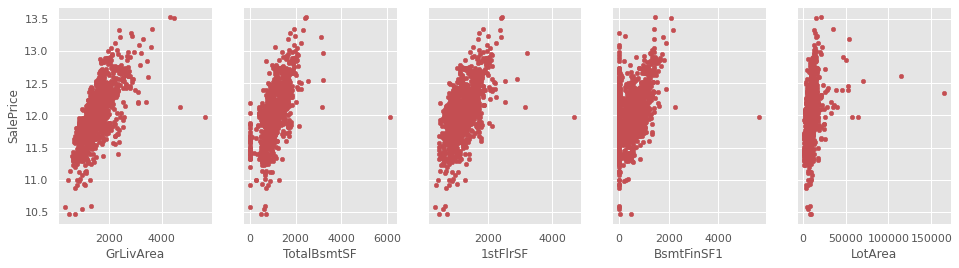

In [37]:
fig, axes = plt.subplots(ncols=5, nrows=1, figsize=(16, 4))
axes = np.ravel(axes)
col_name = ['GrLivArea','TotalBsmtSF','1stFlrSF','BsmtFinSF1','LotArea']
for i, c in zip(range(5), col_name):
    train.plot.scatter(ax=axes[i], x=c, y='SalePrice', sharey=True, colorbar=False, c='r')


In [38]:
qualitative

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

In [39]:
nominal = ['MSZoning', 'Street', 'Alley', 'Utilities', 'LotConfig', 
              'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 
              'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
              'Foundation', 'Heating', 'CentralAir', 'Electrical', 'Functional', 
              'GarageType', 'MiscFeature', 'SaleType', 'SaleCondition']
ordinal = ['LotShape', 'LandContour', 'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual',
            'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 
            'KitchenQual', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 
            'PavedDrive', 'PoolQC', 'Fence']

From categorical variables we have some that are ordinals and some that are nominal. For ordinal variables we'll use target encoding and for nominal we'll use one hot encoding

In [40]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1208,20,RL,70.0,7763,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1962,1980,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,Gd,CBlock,TA,TA,No,Rec,504,BLQ,108,319,931,GasA,TA,Y,SBrkr,1283,0,0,1283,1,0,1,0,3,1,TA,6,Typ,0,None,Detchd,1980.0,Unf,2,506,TA,TA,Y,0,0,0,0,0,0,None,None,None,0,10,2008,WD,Normal,11.849405
1133,60,RL,80.0,9828,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,2Story,8,5,1995,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,No,GLQ,584,Unf,0,544,1128,GasA,Ex,Y,SBrkr,1142,878,0,2020,0,0,2,1,3,1,Gd,8,Typ,1,TA,Attchd,1995.0,RFn,2,466,TA,TA,Y,0,155,0,0,0,0,None,None,None,0,6,2009,WD,Normal,12.386313
309,20,RL,90.0,12378,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,9,5,2003,2004,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Ex,TA,Gd,GLQ,1274,Unf,0,622,1896,GasA,Ex,Y,SBrkr,1944,0,0,1944,1,0,2,0,3,1,Ex,8,Typ,3,Ex,Attchd,2003.0,Fin,3,708,TA,TA,Y,208,175,0,0,0,0,None,None,None,0,11,2006,WD,Normal,12.793862
257,20,RL,68.0,8814,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,1Story,7,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,Stone,180.0,Gd,TA,PConc,Gd,TA,No,GLQ,1334,Unf,0,270,1604,GasA,Ex,Y,SBrkr,1604,0,0,1604,1,0,2,1,3,1,Gd,8,Typ,1,Gd,Attchd,2006.0,RFn,2,660,TA,TA,Y,123,110,0,0,0,0,None,None,None,0,3,2009,WD,Abnorml,12.301387
1318,20,RL,70.0,14781,Pave,None,IR2,Lvl,AllPub,CulDSac,Gtl,CollgCr,Norm,Norm,1Fam,1Story,8,5,2001,2002,Hip,CompShg,VinylSd,VinylSd,BrkFace,178.0,Gd,TA,PConc,Gd,TA,Gd,Unf,0,Unf,0,1753,1753,GasA,Ex,Y,SBrkr,1787,0,0,1787,0,0,2,0,3,1,Gd,7,Typ,1,TA,Attchd,2001.0,RFn,3,748,TA,TA,Y,198,150,0,0,0,0,None,None,None,0,8,2006,WD,Normal,12.524530


**Target encoding**

In [41]:
for var in ordinal:
  mean_encode = train.groupby(var)['SalePrice'].mean()
  train.loc[:, var] = train[var].map(mean_encode)
  test.loc[:, var] = test[var].map(mean_encode)

In [42]:
train.shape

(1168, 80)

In [43]:
test.shape

(292, 80)

In [44]:
for var in ordinal:
    train[var] = train[var].astype("float64")
    test[var] = test[var].astype("float64")

In [45]:
train.dtypes

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice        float64
Length: 80, dtype: object

In [46]:
test.dtypes

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice        float64
Length: 80, dtype: object

GarageYrBlt has category data type, we'll convert it into float

In [47]:
train['GarageYrBlt'] = train['GarageYrBlt'].astype("float64")
test['GarageYrBlt'] = test['GarageYrBlt'].astype("float64")


**One hot encoding**

In [48]:
# With the drop first delete redundant
train = pd.get_dummies(train, drop_first=True)

In [49]:
train.shape

(1168, 202)

In [50]:
test = pd.get_dummies(test, drop_first=True)

In [51]:
test.shape

(292, 176)

As we can see, train and test datasets are of different size so we will use inner join to leave them with the same size

In [52]:
train, test = train.align(test, join='inner', axis=1)

In [53]:
train.shape


(1168, 172)

In [54]:
test.shape

(292, 172)

In [55]:
# Visualize all the features that have missing values
test_missing = test.isna().sum() / test.shape[0]
test_missing[test_missing > 0.0].sort_values(ascending=False)

Series([], dtype: float64)

In [56]:
y_train=train['SalePrice']
X_train=train.drop(["SalePrice"], axis=1)
y_test=test['SalePrice']
X_test=test.drop(["SalePrice"], axis=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1168, 171)
(292, 171)
(1168,)
(292,)


**Models**

We'll start testing with some traditional models like linear regression, random forest and gradient boosting. Then we'll test with more current models like XGBoost, CatBoost and Light GBM.

In [57]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

**Linear Regression**

In [58]:
lr=linear_model.LinearRegression()
lr.fit(X_train,y_train)
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)
mse_train = mean_squared_error(y_train,y_pred_train)
rmse_train = sqrt(mse_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)

print("MSE train: " + str(mse_train))
print("RMSE train: " + str(rmse_train))
print("MAPE train: " + str(mape_train))

mse_test = mean_squared_error(y_test,y_pred_test)
rmse_test = sqrt(mse_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

print("MSE test: " + str(mse_test))
print("RMSE test: " + str(rmse_test))
print("MAPE test: " + str(mape_test))


MSE train: 0.012555007247791286
RMSE train: 0.11204912872392755
MAPE train: 0.6552495586140445
MSE test: 0.01894414519748393
RMSE test: 0.13763773173619193
MAPE test: 0.7658903080209213


**Random Forest**

In [59]:
rfc = RandomForestRegressor()
rfc.fit(X_train, y_train)
y_pred_train = rfc.predict(X_train)
y_pred_test = rfc.predict(X_test)

mse_train = mean_squared_error(y_train,y_pred_train)
rmse_train = sqrt(mse_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)

print("MSE train: " + str(mse_train))
print("RMSE train: " + str(rmse_train))
print("MAPE train: " + str(mape_train))

mse_test = mean_squared_error(y_test,y_pred_test)
rmse_test = sqrt(mse_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

print("MSE test: " + str(mse_test))
print("RMSE test: " + str(rmse_test))
print("MAPE test: " + str(mape_test))


MSE train: 0.0028323386210418917
RMSE train: 0.053219720227016334
MAPE train: 0.2983514944600754
MSE test: 0.017022350310856728
RMSE test: 0.1304697294810437
MAPE test: 0.749722161607577


Here we tested the RF alghoritm with a set of parameters of example and his performance is better than with Linear Regression taking into account the different types of errors.

In [60]:
feature_list = list(train.columns)

# Get numerical feature importances
importances = list(rfc.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances if (pair[1] > 0.0)];


Variable: OverallQual          Importance: 0.54
Variable: GrLivArea            Importance: 0.09
Variable: TotalBsmtSF          Importance: 0.04
Variable: 1stFlrSF             Importance: 0.03
Variable: GarageCars           Importance: 0.03
Variable: GarageArea           Importance: 0.03
Variable: LotArea              Importance: 0.02
Variable: BsmtFinSF1           Importance: 0.02
Variable: LotFrontage          Importance: 0.01
Variable: OverallCond          Importance: 0.01
Variable: YearBuilt            Importance: 0.01
Variable: YearRemodAdd         Importance: 0.01
Variable: BsmtUnfSF            Importance: 0.01
Variable: 2ndFlrSF             Importance: 0.01
Variable: FireplaceQu          Importance: 0.01
Variable: GarageYrBlt          Importance: 0.01
Variable: GarageFinish         Importance: 0.01
Variable: Heating_Wall         Importance: 0.01


These features seems to be the ones with importance in the prediction of Random Forest. We'll make a new set of train and train the model in order to see if the performance improves.

In [61]:
new_train = train[['OverallQual', 'GrLivArea', 'TotalBsmtSF', '1stFlrSF', 'GarageCars',
                  'GarageArea', 'LotArea', 'BsmtFinSF1', 'LotFrontage', 'OverallCond',
                  'YearBuilt', 'YearRemodAdd', 'BsmtUnfSF', '2ndFlrSF', 'FireplaceQu',
                  'GarageYrBlt', 'GarageFinish', 'Heating_Wall', 'SalePrice']]
                   
new_test = test[['OverallQual', 'GrLivArea', 'TotalBsmtSF', '1stFlrSF', 'GarageCars',
                  'GarageArea', 'LotArea', 'BsmtFinSF1', 'LotFrontage', 'OverallCond',
                  'YearBuilt', 'YearRemodAdd', 'BsmtUnfSF', '2ndFlrSF', 'FireplaceQu',
                  'GarageYrBlt', 'GarageFinish', 'Heating_Wall', 'SalePrice']]

In [62]:
new_train.shape

(1168, 19)

In [63]:
new_test.shape

(292, 19)

In [64]:
y_train_new = new_train['SalePrice']
X_train_new = new_train.drop(["SalePrice"], axis=1)
y_test_new = new_test['SalePrice']
X_test_new = new_test.drop(["SalePrice"], axis=1)
print(X_train_new.shape)
print(X_test_new.shape)
print(y_train_new.shape)
print(y_test_new.shape)

(1168, 18)
(292, 18)
(1168,)
(292,)


In [65]:
rfc = RandomForestRegressor()
rfc.fit(X_train_new, y_train_new)
y_pred_train = rfc.predict(X_train_new)
y_pred_test = rfc.predict(X_test_new)

mse_train = mean_squared_error(y_train_new,y_pred_train)
rmse_train = sqrt(mse_train)
mape_train = mean_absolute_percentage_error(y_train_new, y_pred_train)

print("MSE train: " + str(mse_train))
print("RMSE train: " + str(rmse_train))
print("MAPE train: " + str(mape_train))

mse_test = mean_squared_error(y_test_new,y_pred_test)
rmse_test = sqrt(mse_test)
mape_test = mean_absolute_percentage_error(y_test_new, y_pred_test)

print("MSE test: " + str(mse_test))
print("RMSE test: " + str(rmse_test))
print("MAPE test: " + str(mape_test))

MSE train: 0.003007368844328345
RMSE train: 0.05483948253155153
MAPE train: 0.3070038457750108
MSE test: 0.017760181616569004
RMSE test: 0.13326733139283986
MAPE test: 0.7678631530859921


In order to find the better combination of parameters we'll use RandomizedSearch over GridSearch as it's more efficient.

In [66]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=2, n_jobs = -1)


In [67]:
rf_random.fit(X_train, y_train)
rf_random.best_params_


Fitting 3 folds for each of 50 candidates, totalling 150 fits


{'bootstrap': False,
 'max_depth': 110,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 1800}

In [75]:
rfc = RandomForestRegressor(n_estimators = 1800, bootstrap = False, max_depth = 110, max_features = 'sqrt', min_samples_leaf = 1, min_samples_split = 5)
rfc.fit(X_train, y_train)
y_pred_train = rfc.predict(X_train)
y_pred_test = rfc.predict(X_test)

mse_train = mean_squared_error(y_train,y_pred_train)
rmse_train = sqrt(mse_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)

print("MSE train: " + str(mse_train))
print("RMSE train: " + str(rmse_train))
print("MAPE train: " + str(mape_train))

mse_test = mean_squared_error(y_test,y_pred_test)
rmse_test = sqrt(mse_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

print("MSE test: " + str(mse_test))
print("RMSE test: " + str(rmse_test))
print("MAPE test: " + str(mape_test))

MSE train: 0.0007507351592997548
RMSE train: 0.027399546698800598
MAPE train: 0.14054571021932896
MSE test: 0.016311607746479044
RMSE test: 0.12771690470129254
MAPE test: 0.7202303643743075


**Gradient Boosting**

In [68]:
grad_boost = GradientBoostingRegressor()
grad_boost.fit(X_train, y_train)
y_pred_train = grad_boost.predict(X_train)
y_pred_test = grad_boost.predict(X_test)

mse_train = mean_squared_error(y_train,y_pred_train)
rmse_train = sqrt(mse_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)

print("MSE train: " + str(mse_train))
print("RMSE train: " + str(rmse_train))
print("MAPE train: " + str(mape_train))

mse_test = mean_squared_error(y_test,y_pred_test)
rmse_test = sqrt(mse_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

print("MSE test: " + str(mse_test))
print("RMSE test: " + str(rmse_test))
print("MAPE test: " + str(mape_test))

MSE train: 0.006173571663949031
RMSE train: 0.07857207941723976
MAPE train: 0.4887702768708575
MSE test: 0.01431944839131574
RMSE test: 0.11966389761041439
MAPE test: 0.6890484583604197


In [69]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
learning_rate = [0.05,0.1,0.3]
max_depth = [int(x) for x in np.linspace(3, 18, num = 6)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
max_features = ['auto', 'sqrt']
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_features': max_features}

# Create a based model
grad_boost = GradientBoostingRegressor()
# Instantiate the grid search model
grad_search = RandomizedSearchCV(estimator = grad_boost, param_distributions = random_grid, n_iter = 50,
                          cv = 3, n_jobs = -1, verbose = 2)

In [70]:
grad_search.fit(X_train, y_train)
grad_search.best_params_


Fitting 3 folds for each of 50 candidates, totalling 150 fits


{'learning_rate': 0.05,
 'max_depth': 3,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1800}

In [76]:
grad_boost = GradientBoostingRegressor(n_estimators = 1800, max_features = 'sqrt',
                                       max_depth = 3, learning_rate = 0.05,
                                       min_samples_leaf = 1, min_samples_split = 2)
grad_boost.fit(X_train, y_train)
y_pred_train = grad_boost.predict(X_train)
y_pred_test = grad_boost.predict(X_test)

mse_train = mean_squared_error(y_train,y_pred_train)
rmse_train = sqrt(mse_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)

print("MSE train: " + str(mse_train))
print("RMSE train: " + str(rmse_train))
print("MAPE train: " + str(mape_train))

mse_test = mean_squared_error(y_test,y_pred_test)
rmse_test = sqrt(mse_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

print("MSE test: " + str(mse_test))
print("RMSE test: " + str(rmse_test))
print("MAPE test: " + str(mape_test))

MSE train: 0.0008620127158809963
RMSE train: 0.029360053063320513
MAPE train: 0.18228868720843555
MSE test: 0.013313559988943686
RMSE test: 0.11538440097753112
MAPE test: 0.6720941243748332


Now we'll try some current models and other libraries.

**XGB Regressor**

In [72]:
xgb = xgboost.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,             
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42) 

xgb.fit(X_train, y_train)
y_pred_train = xgb.predict(X_train)
y_pred_test = xgb.predict(X_test)

mse_train = mean_squared_error(y_train,y_pred_train)
rmse_train = sqrt(mse_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)

print("MSE train: " + str(mse_train))
print("RMSE train: " + str(rmse_train))
print("MAPE train: " + str(mape_train))

mse_test = mean_squared_error(y_test,y_pred_test)
rmse_test = sqrt(mse_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

print("MSE test: " + str(mse_test))
print("RMSE test: " + str(rmse_test))
print("MAPE test: " + str(mape_test))

[16:34:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE train: 0.0008001584579358592
RMSE train: 0.028287072275791626
MAPE train: 0.16655175178502446
MSE test: 0.013774736557011077
RMSE test: 0.11736582363282369
MAPE test: 0.6855164247458314


**CatBoost Regressor**

In [73]:
cat_model = catboost.CatBoostRegressor(loss_function='RMSE', 
                                       random_seed=2, 
                                       max_depth = 10,
                                       learning_rate = 0.05,
                                       random_strength=1,
                                       max_ctr_complexity=1,
                                       l2_leaf_reg=8,
                                       grow_policy = 'Lossguide',
                                       task_type='GPU',
                                      )


cat_model.fit(X_train, y_train)
y_pred_train = cat_model.predict(X_train)
y_pred_test = cat_model.predict(X_test)

mse_train = mean_squared_error(y_train,y_pred_train)
rmse_train = sqrt(mse_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)

print("MSE train: " + str(mse_train))
print("RMSE train: " + str(rmse_train))
print("MAPE train: " + str(mape_train))

mse_test = mean_squared_error(y_test,y_pred_test)
rmse_test = sqrt(mse_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

print("MSE test: " + str(mse_test))
print("RMSE test: " + str(rmse_test))
print("MAPE test: " + str(mape_test))

0:	learn: 0.3899067	total: 20.9ms	remaining: 20.9s
1:	learn: 0.3759970	total: 37.5ms	remaining: 18.7s
2:	learn: 0.3629595	total: 53.8ms	remaining: 17.9s
3:	learn: 0.3504078	total: 69.9ms	remaining: 17.4s
4:	learn: 0.3385296	total: 86.1ms	remaining: 17.1s
5:	learn: 0.3272242	total: 102ms	remaining: 16.9s
6:	learn: 0.3165885	total: 118ms	remaining: 16.8s
7:	learn: 0.3062915	total: 135ms	remaining: 16.7s
8:	learn: 0.2963107	total: 151ms	remaining: 16.6s
9:	learn: 0.2870171	total: 174ms	remaining: 17.2s
10:	learn: 0.2779256	total: 198ms	remaining: 17.8s
11:	learn: 0.2696300	total: 214ms	remaining: 17.6s
12:	learn: 0.2613561	total: 234ms	remaining: 17.8s
13:	learn: 0.2536151	total: 250ms	remaining: 17.6s
14:	learn: 0.2461225	total: 267ms	remaining: 17.5s
15:	learn: 0.2390515	total: 283ms	remaining: 17.4s
16:	learn: 0.2324789	total: 299ms	remaining: 17.3s
17:	learn: 0.2259232	total: 315ms	remaining: 17.2s
18:	learn: 0.2195755	total: 331ms	remaining: 17.1s
19:	learn: 0.2136740	total: 347ms	re

**Light GBM**

In [74]:
lgbm_regressor = lgb.LGBMRegressor(colsample_bytree = 0.7, 
                                       max_depth = 45,
                                       learning_rate = 0.06,
                                       min_child_weight = 3.3,
                                       n_estimators = 700,
                                       num_leaves = 50
                                      )

lgbm_regressor.fit(X_train, y_train)
y_pred_train = lgbm_regressor.predict(X_train)
y_pred_test = lgbm_regressor.predict(X_test)

mse_train = mean_squared_error(y_train,y_pred_train)
rmse_train = sqrt(mse_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)

print("MSE train: " + str(mse_train))
print("RMSE train: " + str(rmse_train))
print("MAPE train: " + str(mape_train))

mse_test = mean_squared_error(y_test,y_pred_test)
rmse_test = sqrt(mse_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

print("MSE test: " + str(mse_test))
print("RMSE test: " + str(rmse_test))
print("MAPE test: " + str(mape_test))

MSE train: 5.3459459275435565e-05
RMSE train: 0.007311597587082837
MAPE train: 0.02093806724994726
MSE test: 0.015807086475943827
RMSE test: 0.12572623622754253
MAPE test: 0.7220748412409389


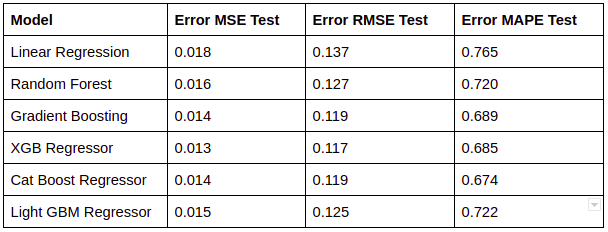

Now we're going to try some other tools like optuna, shap values in order to improve our work. We'll use these tools with Random Forest and XGB Regressor

In [82]:

# 10-fold CV
kfolds = KFold(n_splits=10, shuffle=True)

# Define the helper function so that it can be reused
def tune(objective):
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=100)

    params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score}\n")
    print(f"Optimized parameters: {params}\n")
    return params

In [83]:
def rmse(model,x,y):
    return -(cross_val_score(model, x, y, cv=kfolds, scoring='neg_root_mean_squared_error',n_jobs=-1))

In [84]:
##################
# Random Forest
##################
def randomforest_objective(trial):
    _n_estimators = trial.suggest_int("n_estimators", 300, 2000)
    _max_depth = trial.suggest_int("max_depth", 2, 20)
    _min_samp_split = trial.suggest_int("min_samples_split", 2, 10)
    _min_samples_leaf = trial.suggest_int("min_samples_leaf", 2, 10)
    _max_features = trial.suggest_int("max_features", 2, 50)

    rf = RandomForestRegressor(
        max_depth=_max_depth,
        min_samples_split=_min_samp_split,
        min_samples_leaf=_min_samples_leaf,
        max_features=_max_features,
        n_estimators=_n_estimators,
        n_jobs=-1,
    )

    scores = rmse(rf, X_train, y_train)
    return scores.mean()

randomforest_params = tune(randomforest_objective)
rf = RandomForestRegressor(n_jobs=-1, **randomforest_params)


[I 2021-04-29 17:27:37,733] A new study created in memory with name: no-name-69f981d4-f6e1-4dcf-b5b7-bf07c0fa5eea
[I 2021-04-29 17:27:52,752] Trial 0 finished with value: 0.14207737964912995 and parameters: {'n_estimators': 413, 'max_depth': 16, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 44}. Best is trial 0 with value: 0.14207737964912995.
[I 2021-04-29 17:28:34,701] Trial 1 finished with value: 0.14159161892123392 and parameters: {'n_estimators': 1424, 'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 39}. Best is trial 1 with value: 0.14159161892123392.
[I 2021-04-29 17:28:51,285] Trial 2 finished with value: 0.16912440931708025 and parameters: {'n_estimators': 823, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 47}. Best is trial 1 with value: 0.14159161892123392.
[I 2021-04-29 17:29:16,053] Trial 3 finished with value: 0.14911163356519105 and parameters: {'n_estimators': 938, 'max_depth': 14, 'min_sa

Best score: 0.1384182830330344

Optimized parameters: {'n_estimators': 1704, 'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 50}



In [85]:
rfc = RandomForestRegressor(n_estimators = 1704, max_depth = 20, min_samples_leaf = 2, min_samples_split = 6, max_features=50)
rfc.fit(X_train, y_train)
y_pred_train = rfc.predict(X_train)
y_pred_test = rfc.predict(X_test)
mse_train = mean_squared_error(y_train,y_pred_train)
rmse_train = sqrt(mse_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)

print("MSE train: " + str(mse_train))
print("RMSE train: " + str(rmse_train))
print("MAPE train: " + str(mape_train))

mse_test = mean_squared_error(y_test,y_pred_test)
rmse_test = sqrt(mse_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

print("MSE test: " + str(mse_test))
print("RMSE test: " + str(rmse_test))
print("MAPE test: " + str(mape_test))

MSE train: 0.005248967976357614
RMSE train: 0.07244976174120667
MAPE train: 0.37985992591208495
MSE test: 0.016148585151998397
RMSE test: 0.12707708350445565
MAPE test: 0.7187091214808954


In [87]:
##################
# XGBoost
##################
def xgboost_objective(trial):
    _colsample_bytree = trial.suggest_float("colsample_bytree", 0.1, 0.9, log = True)
    _gamma = trial.suggest_int("gamma", 0, 10)
    _n_estimators = trial.suggest_int('n_estimators',50,3000,50) 
    _learning_rate = trial.suggest_float("learning_rate", 0.1, 0.6, log = True)
    _max_depth = trial.suggest_int("max_depth", 3, 9)
    _min_child_weight = trial.suggest_int("min_child_weight", 1, 9)
    _reg_alpha = trial.suggest_float("reg_alpha", 0.3, 0.9, log = True)
    _reg_lambda = trial.suggest_float("reg_lambda", 0.3, 0.9, log = True)
    _subsample = trial.suggest_float("subsample", 0.1, 0.9, log = True)
    xgb = xgboost.XGBRegressor(
        colsample_bytree=_colsample_bytree,
        gamma = _gamma,
        n_estimators = _n_estimators,
        learning_rate = _learning_rate,
        max_depth = _max_depth,
        min_child_weight = _min_child_weight,
        reg_alpha = _reg_alpha,
        reg_lambda = _reg_lambda,
        subsample = _subsample,
        n_jobs=-1,
    )

    scores = rmse(xgb, X_train, y_train)
    return scores.mean()

xgboost_params = tune(xgboost_objective)
xgb = xgboost.XGBRegressor(n_jobs=-1, **xgboost_params)

[I 2021-04-29 19:01:47,812] A new study created in memory with name: no-name-7b1891cf-83f0-4a79-ae5b-29df82a5a553
[I 2021-04-29 19:02:50,029] Trial 0 finished with value: 0.22325616891443692 and parameters: {'colsample_bytree': 0.2929549786698637, 'gamma': 8, 'n_estimators': 2350, 'learning_rate': 0.1747744209281295, 'max_depth': 6, 'min_child_weight': 2, 'reg_alpha': 0.45751054731163193, 'reg_lambda': 0.7544360545405187, 'subsample': 0.8493260347278222}. Best is trial 0 with value: 0.22325616891443692.
[I 2021-04-29 19:02:59,236] Trial 1 finished with value: 0.1843878195102551 and parameters: {'colsample_bytree': 0.23765048048960105, 'gamma': 2, 'n_estimators': 350, 'learning_rate': 0.2978233339266815, 'max_depth': 7, 'min_child_weight': 2, 'reg_alpha': 0.37305704373925286, 'reg_lambda': 0.32429565191841614, 'subsample': 0.44893930884584776}. Best is trial 1 with value: 0.1843878195102551.
[I 2021-04-29 19:03:09,697] Trial 2 finished with value: 0.1816917546262437 and parameters: {'co

Best score: 0.12570564710872725

Optimized parameters: {'colsample_bytree': 0.22809891993991988, 'gamma': 0, 'n_estimators': 1750, 'learning_rate': 0.10373030598044997, 'max_depth': 4, 'min_child_weight': 9, 'reg_alpha': 0.49149963567521393, 'reg_lambda': 0.7108116411390258, 'subsample': 0.529624633060129}



In [90]:
xgb = xgboost.XGBRegressor(colsample_bytree= 0.22809891993991988,
                 gamma=0,             
                 learning_rate=0.10373030598044997,
                 max_depth=4,
                 min_child_weight=9,
                 n_estimators=1750,                                                                    
                 reg_alpha=0.49149963567521393,
                 reg_lambda=0.7108116411390258,
                 subsample=0.529624633060129) 

xgb.fit(X_train, y_train)
y_pred_train = xgb.predict(X_train)
y_pred_test = xgb.predict(X_test)

mse_train = mean_squared_error(y_train,y_pred_train)
rmse_train = sqrt(mse_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)

print("MSE train: " + str(mse_train))
print("RMSE train: " + str(rmse_train))
print("MAPE train: " + str(mape_train))

mse_test = mean_squared_error(y_test,y_pred_test)
rmse_test = sqrt(mse_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

print("MSE test: " + str(mse_test))
print("RMSE test: " + str(rmse_test))
print("MAPE test: " + str(mape_test))

[20:25:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE train: 0.0009611670985150297
RMSE train: 0.03100269502019187
MAPE train: 0.18454486201485956
MSE test: 0.014492691070383559
RMSE test: 0.12038559328417815
MAPE test: 0.7151482003915851


The use of optuna improves our performance in Random Forest. We should run with more trials in XGBoost in order to find a best combination of parameters

In [91]:
xgb = xgboost.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,             
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42) 

xgb.fit(X_train, y_train)
y_pred_train = xgb.predict(X_train)
y_pred_test = xgb.predict(X_test)

mse_train = mean_squared_error(y_train,y_pred_train)
rmse_train = sqrt(mse_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)

print("MSE train: " + str(mse_train))
print("RMSE train: " + str(rmse_train))
print("MAPE train: " + str(mape_train))

mse_test = mean_squared_error(y_test,y_pred_test)
rmse_test = sqrt(mse_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

print("MSE test: " + str(mse_test))
print("RMSE test: " + str(rmse_test))
print("MAPE test: " + str(mape_test))

[20:29:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE train: 0.0008001584579358592
RMSE train: 0.028287072275791626
MAPE train: 0.16655175178502446
MSE test: 0.013774736557011077
RMSE test: 0.11736582363282369
MAPE test: 0.6855164247458314


In [93]:
rfc = RandomForestRegressor(n_estimators = 1704, max_depth = 20, min_samples_leaf = 2, min_samples_split = 6, max_features=50)
rfc.fit(X_train, y_train)
y_pred_train = rfc.predict(X_train)
y_pred_test = rfc.predict(X_test)
mse_train = mean_squared_error(y_train,y_pred_train)
rmse_train = sqrt(mse_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)

print("MSE train: " + str(mse_train))
print("RMSE train: " + str(rmse_train))
print("MAPE train: " + str(mape_train))

mse_test = mean_squared_error(y_test,y_pred_test)
rmse_test = sqrt(mse_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

print("MSE test: " + str(mse_test))
print("RMSE test: " + str(rmse_test))
print("MAPE test: " + str(mape_test))

MSE train: 0.005225127356854613
RMSE train: 0.0722850424144208
MAPE train: 0.3792428881174037
MSE test: 0.016144839624363413
RMSE test: 0.12706234542288056
MAPE test: 0.7198527655134553


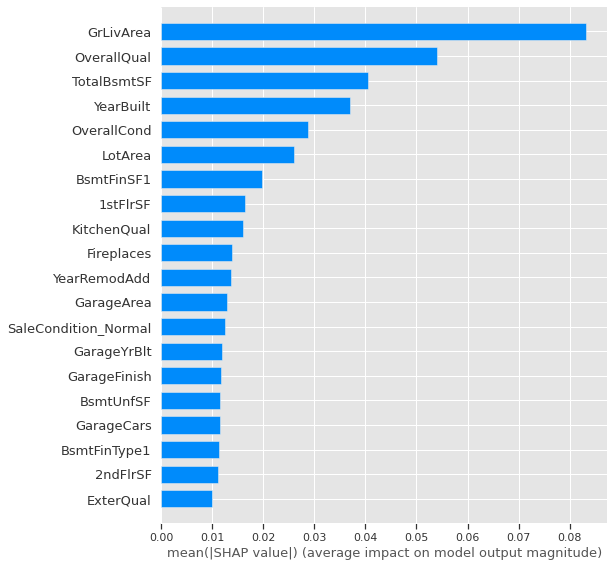

In [94]:
explainer_xgb = shap.TreeExplainer(xgb)
shap_values_xgb = explainer_xgb.shap_values(X_test, y_test, approximate=True)

shap.summary_plot(shap_values_xgb, X_test, plot_type = 'bar')

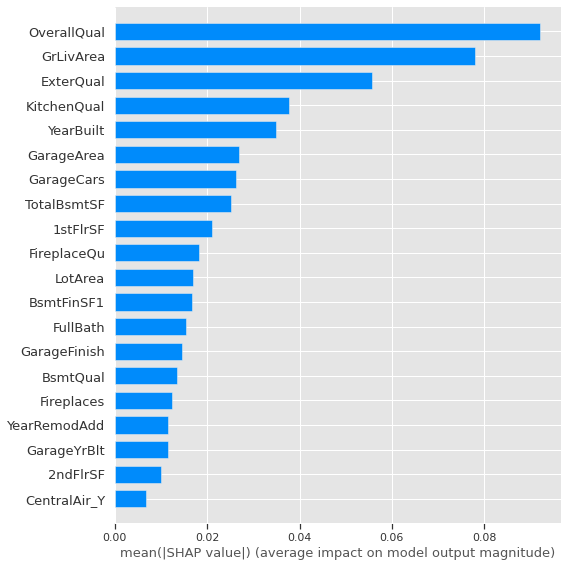

In [95]:
explainer_rfc = shap.TreeExplainer(rfc)
shap_values_rfc = explainer_rfc.shap_values(X_test, y_test, approximate=True)

shap.summary_plot(shap_values_rfc, X_test, plot_type = 'bar')

OverallQual, GrLivArea and ExterQual are the most powerful contributers/influencers to the SalePrice regression in both models. We'll take random forest and take a look in his behaviour

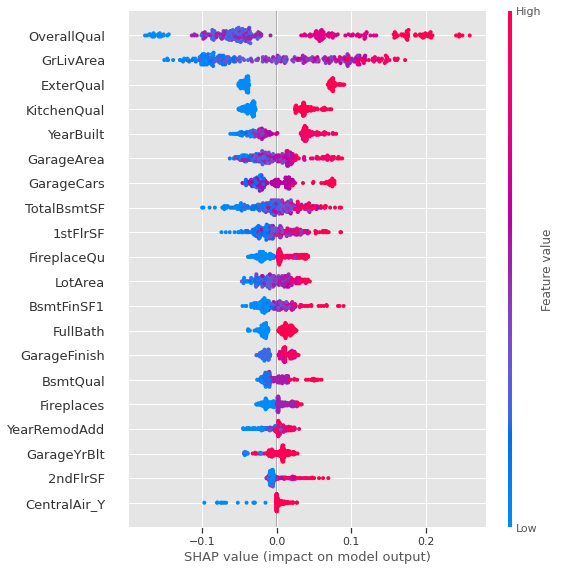

In [96]:
shap.summary_plot(shap_values_rfc, X_test)

Majority of the top features have positive correlation with the SalePrices. Higher values equate to higher prices while lower values equate to lower prices.

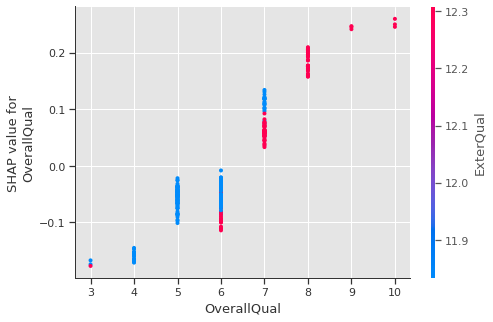

In [98]:
shap.dependence_plot("OverallQual", shap_values_rfc, X_test)


High values of OverallQual means high sale prices and high values of ExterQual and the same in the opposite. Low values of OverallQual and ExterQual decrease the sale price


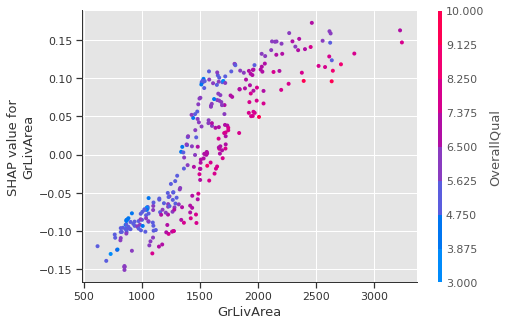

In [97]:
shap.dependence_plot("GrLivArea", shap_values_rfc, X_test)


We can see like a linear relationship between GrLivArea and the sale price. With high values of GrLivArea the sale price is higher. And also in most cases OverallQual is high when GrLivArea is high.

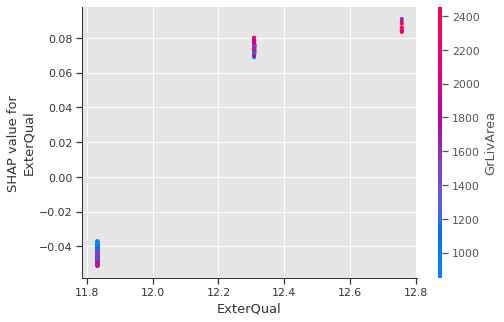

In [99]:
shap.dependence_plot("ExterQual", shap_values_rfc, X_test)


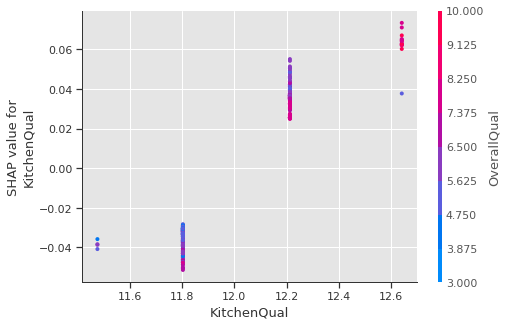

In [100]:
shap.dependence_plot("KitchenQual", shap_values_rfc, X_test)


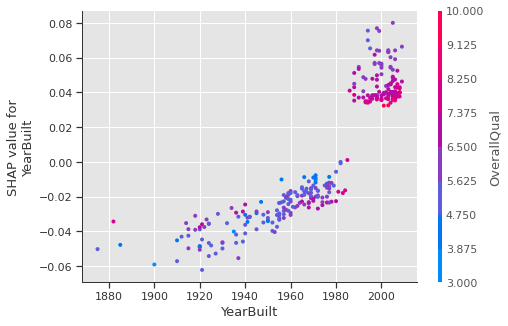

In [101]:
shap.dependence_plot("YearBuilt", shap_values_rfc, X_test)


This graph is a bit special. After 1980 the sale price increases a lot and also the OverallQual. Maybe in these years there was a tendency to start building more comfortable and better houses.

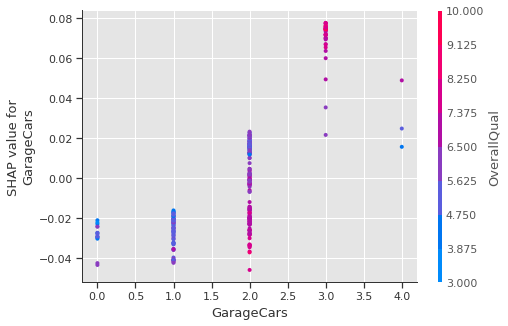

In [102]:
shap.dependence_plot("GarageCars", shap_values_rfc, X_test)


Big garages are related to high values of OverallQual and sale price

In [103]:
# Get the predictions and put them with the test data.
X_output = X_test.copy()
X_output.loc[:,'predict'] = np.round(rfc.predict(X_output),2)
# X_output['predict'] = np.exp(X_output['predict'])

# Randomly pick some observations
random_picks = np.arange(1,292,50) # Every 50 rows
S = X_output.iloc[random_picks]
S

,MSSubClass,LotFrontage,LotArea,LotShape,LandContour,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,...,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Heating_GasW,Heating_Grav,Heating_Wall,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_SBrkr,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Typ,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,MiscFeature_Shed,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,predict
194,20,60.0,7180,12.161655,12.016163,12.013046,5,7,1972,1972,0.0,11.832658,12.036505,11.805346,12.035898,12.137966,11.960074,390,12.034664,0,474,864,11.799364,864,0,0,864,0,0,1,0,3,1,11.803007,5,0,11.798271,1989.0,11.813265,1,...,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,11.72
169,20,70.0,16669,12.161655,12.016163,12.013046,8,6,1981,1981,653.0,12.308526,12.036505,12.161901,12.035898,11.949389,11.945982,0,12.034664,0,1686,1686,11.799364,1707,0,0,1707,0,0,2,1,2,1,11.803007,6,1,12.188739,1981.0,12.159428,2,...,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,12.36
838,20,75.0,9525,11.929105,12.016163,12.013046,5,6,1995,2006,0.0,11.832658,12.036505,12.161901,12.035898,11.949389,11.945982,0,12.034664,0,1099,1099,12.196536,1099,0,0,1099,0,0,1,1,3,1,12.212717,6,0,11.798271,1999.0,11.813265,1,...,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,11.87
327,20,80.0,11600,11.929105,12.016163,12.013046,6,5,1960,1960,175.0,11.832658,12.036505,11.805346,12.035898,11.949389,11.850269,565,12.034664,0,818,1383,11.799364,1383,0,0,1383,0,0,1,1,3,1,11.803007,7,0,11.798271,1960.0,12.159428,1,...,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,11.92
493,20,70.0,7931,11.929105,12.016163,12.013046,5,6,1960,1960,0.0,11.832658,12.036505,11.805346,12.035898,11.949389,11.849573,374,11.944492,532,363,1269,11.799364,1269,0,0,1269,0,0,1,1,3,1,11.803007,6,1,12.001874,1964.0,11.813265,1,...,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,11.87
531,70,60.0,6155,12.161655,12.016163,12.013046,6,8,1920,1999,0.0,11.832658,12.036505,11.590139,11.639344,12.084799,11.945982,0,12.034664,0,611,611,12.196536,751,611,0,1362,0,0,2,0,3,1,11.803007,6,0,11.798271,1920.0,12.331760,2,...,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,11.73


In [104]:
# Initialize your Jupyter notebook with initjs(), otherwise you will get an error message.
shap.initjs()

# Write in a function
def shap_plot(j):
    shap_values_Model = explainer_rfc.shap_values(S)
    p = shap.force_plot(explainer_rfc.expected_value, shap_values_Model[j], S.iloc[[j]])
    return(p)

In [105]:
shap.initjs()

shap_plot(0)

The output value is the prediction for the first observation in this case. The value of predict in the table above for the first row is 11.72. Remember that we have our sales prices with the log applied. The base value is the mean prediction. Let's discuss some impact of some variables.

In [109]:
print("Mean of GrLivArea: " + str(mean(X_test['GrLivArea'])))
print("Mean of OverallQual: " + str(mean(X_test['OverallQual'])))
print("Mean of ExterQual: " + str(mean(X_test['ExterQual'])))
print("Mean of KitchenQual: " + str(mean(X_test['KitchenQual'])))
print("Mean of Garage Cars: " + str(mean(X_test['GarageCars'])))
print("Mean of FireplaceQu: " + str(mean(X_test['FireplaceQu'])))
print("Mean of Year Built: " + str(mean(X_test['YearBuilt'])))
print("Mean of TotalBsmtSF: " + str(mean(X_test['TotalBsmtSF'])))
print("Mean of FullBath: " + str(mean(X_test['FullBath'])))
print("Mean of GarageYrBlt: " + str(mean(X_test['GarageYrBlt'])))
print("Mean of OverallCond: " + str(mean(X_test['OverallCond'])))


Mean of GrLivArea: 1519.3287671232877
Mean of OverallQual: 6.178082191780822
Mean of ExterQual: 12.035619467527612
Mean of KitchenQual: 12.0183040063644
Mean of Garage Cars: 1.8150684931506849
Mean of FireplaceQu: 12.019669671436638
Mean of Year Built: 1973.3938356164383
Mean of TotalBsmtSF: 1049.1198630136987
Mean of FullBath: 1.5856164383561644
Mean of GarageYrBlt: 1878.4041095890411
Mean of OverallCond: 5.575342465753424


GarageYrBlt and OverallCond are both bigger than the average so they push the prediction to the right. However, for example GrLivArea and OverallQual are smaller than the average so they push the prediction to the left

In [110]:
shap.initjs()

shap_plot(1)

In this example most of our more importante features are bigger than the mean so they push the prediction to the right.

In [111]:
real_value=pd.DataFrame({'count':np.exp(y_test)})
predict_value=pd.DataFrame({'count':np.exp(y_pred_test)})
with pd.ExcelWriter('c:\\test.xls') as writer:
    real_value.to_excel(writer, sheet_name='Sheet1')
    predict_value.to_excel(writer, sheet_name='Sheet2')

As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.


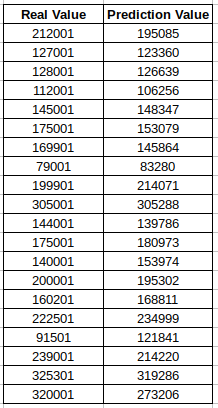

Let's check some examples of our predicted values.

In [112]:
X_test.loc[619, [ 'OverallQual',
'GrLivArea',
'ExterQual',
'KitchenQual',
'YearBuilt',
'GarageArea',
'GarageCars',
'TotalBsmtSF',
'1stFlrSF',
'FireplaceQu',
'LotArea',
'BsmtFinSF1',
'FullBath',
'GarageFinish',
'BsmtQual',
'Fireplaces',
'YearRemodAdd',
'GarageYrBlt',
'2ndFlrSF',
'CentralAir_Y',
]]

OverallQual         8.000000
GrLivArea        2262.000000
ExterQual          12.308526
KitchenQual        12.212717
YearBuilt        2003.000000
GarageArea        749.000000
GarageCars          3.000000
TotalBsmtSF      1482.000000
1stFlrSF         1482.000000
FireplaceQu        12.243598
LotArea         12244.000000
BsmtFinSF1        871.000000
FullBath            2.000000
GarageFinish       12.331760
BsmtQual           12.161901
Fireplaces          2.000000
YearRemodAdd     2003.000000
GarageYrBlt      2003.000000
2ndFlrSF          780.000000
CentralAir_Y        1.000000
Name: 619, dtype: float64

In [113]:
print("The real value is: " + str(round(np.exp(y_test.loc[619]))))
print("The predicted value is: " + str(round(np.exp(y_pred_test[9]))))

The real value is: 305001
The predicted value is: 305289


In [114]:
example = X_test.loc[619,:]
shap.initjs()

shap_values_Model = explainer_rfc.shap_values(example)
shap.force_plot(explainer_rfc.expected_value, shap_values_Model, example)

In [115]:
print("Mean of GrLivArea: " + str(mean(X_test['GrLivArea'])))
print("Mean of OverallQual: " + str(mean(X_test['OverallQual'])))
print("Mean of ExterQual: " + str(mean(X_test['ExterQual'])))
print("Mean of KitchenQual: " + str(mean(X_test['KitchenQual'])))
print("Mean of Garage Cars: " + str(mean(X_test['GarageCars'])))
print("Mean of FireplaceQu: " + str(mean(X_test['FireplaceQu'])))
print("Mean of Year Built: " + str(mean(X_test['YearBuilt'])))
print("Mean of TotalBsmtSF: " + str(mean(X_test['TotalBsmtSF'])))
print("Mean of FullBath: " + str(mean(X_test['FullBath'])))
print("Mean of GarageArea: " + str(mean(X_test['GarageArea'])))
print("Mean of BsmtQual: " + str(mean(X_test['BsmtQual'])))
print("Mean of GarageFinish: " + str(mean(X_test['GarageFinish'])))
print("Mean of 1stFlrSF: " + str(mean(X_test['1stFlrSF'])))
print("Mean of GarageYrBlt: " + str(mean(X_test['GarageYrBlt'])))
print("Mean of Fireplaces: " + str(mean(X_test['Fireplaces'])))
print("Mean of YearRemodAdd: " + str(mean(X_test['YearRemodAdd'])))
print("Mean of LotArea: " + str(mean(X_test['LotArea'])))
print("Mean of BsmtFinSF1: " + str(mean(X_test['BsmtFinSF1'])))
print("Mean of TotRmsAbvGrd: " + str(mean(X_test['TotRmsAbvGrd'])))
print("Mean of CentralAir_Y: " + str(mean(X_test['CentralAir_Y'])))


Mean of GrLivArea: 1519.3287671232877
Mean of OverallQual: 6.178082191780822
Mean of ExterQual: 12.035619467527612
Mean of KitchenQual: 12.0183040063644
Mean of Garage Cars: 1.8150684931506849
Mean of FireplaceQu: 12.019669671436638
Mean of Year Built: 1973.3938356164383
Mean of TotalBsmtSF: 1049.1198630136987
Mean of FullBath: 1.5856164383561644
Mean of GarageArea: 483.5821917808219
Mean of BsmtQual: 12.014899306304189
Mean of GarageFinish: 12.036529240848212
Mean of 1stFlrSF: 1151.9691780821918
Mean of GarageYrBlt: 1878.4041095890411
Mean of Fireplaces: 0.6301369863013698
Mean of YearRemodAdd: 1985.5890410958905
Mean of LotArea: 10998.763698630137
Mean of BsmtFinSF1: 424.2054794520548
Mean of TotRmsAbvGrd: 6.5479452054794525
Mean of CentralAir_Y: 0.952054794520548


In [116]:
X_test.loc[159, [ 'OverallQual',
'GrLivArea',
'ExterQual',
'KitchenQual',
'YearBuilt',
'GarageArea',
'GarageCars',
'TotalBsmtSF',
'1stFlrSF',
'FireplaceQu',
'LotArea',
'BsmtFinSF1',
'FullBath',
'GarageFinish',
'BsmtQual',
'Fireplaces',
'YearRemodAdd',
'GarageYrBlt',
'2ndFlrSF',
'CentralAir_Y',
]]

OverallQual         7.000000
GrLivArea        2462.000000
ExterQual          12.308526
KitchenQual        12.212717
YearBuilt        2005.000000
GarageArea        576.000000
GarageCars          2.000000
TotalBsmtSF      1392.000000
1stFlrSF         1392.000000
FireplaceQu        12.243598
LotArea         19378.000000
BsmtFinSF1         57.000000
FullBath            2.000000
GarageFinish       12.159428
BsmtQual           12.161901
Fireplaces          1.000000
YearRemodAdd     2006.000000
GarageYrBlt      2006.000000
2ndFlrSF         1070.000000
CentralAir_Y        1.000000
Name: 159, dtype: float64

In [117]:
print("The real value is: " + str(round(np.exp(y_test.loc[159]))))
print("The predicted value is: " + str(round(np.exp(y_pred_test[19]))))

The real value is: 320001
The predicted value is: 273206


In [118]:
example = X_test.loc[159,:]
shap.initjs()

shap_values_Model = explainer_rfc.shap_values(example)
shap.force_plot(explainer_rfc.expected_value, shap_values_Model, example)

In [120]:
X_test.loc[175, [ 'OverallQual',
'GrLivArea',
'ExterQual',
'KitchenQual',
'YearBuilt',
'GarageArea',
'GarageCars',
'TotalBsmtSF',
'1stFlrSF',
'FireplaceQu',
'LotArea',
'BsmtFinSF1',
'FullBath',
'GarageFinish',
'BsmtQual',
'Fireplaces',
'YearRemodAdd',
'GarageYrBlt',
'2ndFlrSF',
'CentralAir_Y'
]]

OverallQual         6.000000
GrLivArea        2158.000000
ExterQual          11.832658
KitchenQual        12.212717
YearBuilt        1950.000000
GarageArea        576.000000
GarageCars          2.000000
TotalBsmtSF      1202.000000
1stFlrSF         2158.000000
FireplaceQu        12.243598
LotArea         12615.000000
BsmtFinSF1        477.000000
FullBath            2.000000
GarageFinish       11.813265
BsmtQual           11.805346
Fireplaces          1.000000
YearRemodAdd     2001.000000
GarageYrBlt      1950.000000
2ndFlrSF            0.000000
CentralAir_Y        1.000000
Name: 175, dtype: float64

In [121]:
print("The real value is: " + str(round(np.exp(y_test.loc[175]))))
print("The predicted value is: " + str(round(np.exp(y_pred_test[21]))))

The real value is: 243001
The predicted value is: 206868


In [122]:
example = X_test.loc[175,:]
shap.initjs()

shap_values_Model = explainer_rfc.shap_values(example)
shap.force_plot(explainer_rfc.expected_value, shap_values_Model, example)

In [123]:
X_test.loc[764, [ 'OverallQual',
'GrLivArea',
'ExterQual',
'KitchenQual',
'YearBuilt',
'GarageArea',
'GarageCars',
'TotalBsmtSF',
'1stFlrSF',
'FireplaceQu',
'LotArea',
'BsmtFinSF1',
'FullBath',
'GarageFinish',
'BsmtQual',
'Fireplaces',
'YearRemodAdd',
'GarageYrBlt',
'2ndFlrSF',
'CentralAir_Y'
]]

OverallQual        8.000000
GrLivArea       1494.000000
ExterQual         12.308526
KitchenQual       12.641095
YearBuilt       1995.000000
GarageArea       481.000000
GarageCars         2.000000
TotalBsmtSF     1494.000000
1stFlrSF        1494.000000
FireplaceQu       12.243598
LotArea         9549.000000
BsmtFinSF1       437.000000
FullBath           1.000000
GarageFinish      12.331760
BsmtQual          12.161901
Fireplaces         1.000000
YearRemodAdd    1996.000000
GarageYrBlt     1995.000000
2ndFlrSF           0.000000
CentralAir_Y       1.000000
Name: 764, dtype: float64

In [124]:
print("The real value is: " + str(round(np.exp(y_test.loc[764]))))
print("The predicted value is: " + str(round(np.exp(y_pred_test[24]))))

The real value is: 270001
The predicted value is: 220647


In [125]:
example = X_test.loc[764,:]
shap.initjs()

shap_values_Model = explainer_rfc.shap_values(example)
shap.force_plot(explainer_rfc.expected_value, shap_values_Model, example)